In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import pickle as pckl
%matplotlib inline
sns.set_style("whitegrid")

import os

In [4]:
import sys
sys.path.append('../code/')
import make_genesets

In [4]:
#get good signature threshold
def create_good_geneset_matrix(bname='gdsc',abstype='_abs',rtype='_filtered'):
    datasets=['BEST_dorothea_AB','BEST_dorothea_CD','CGP','KEGG','BIOCARTA','REACTOME']
    scores=[]
    for fname in datasets:
        data=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,fname,rtype,abstype),
                         sep=',',header=0,index_col=0)
        scores+=list(data.values.reshape((1,-1))[0])
    scores=np.array(scores)
    th=np.std(scores)*2.5
    for fname in datasets:
        data=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,fname,rtype,abstype),
                         sep=',',header=0,index_col=0)
        data=(data.abs()>th)*1
        data.to_csv('../results/genesets/good/%s/%s%s%s.csv' % (bname,fname,rtype,abstype))

In [5]:
for bname in ['progeny','gdsc']:
    for abstype in ['','_abs']:
        for rtype in ['_filtered','_random']:
            create_good_geneset_matrix(bname,abstype,rtype) 

In [5]:
#write filterd gene sets to csv
datasets=['BEST_dorothea_AB','BEST_dorothea_CD','CGP','KEGG','BIOCARTA','REACTOME']
for dataset in datasets:
    make_genesets.make_pickle_from_genese(dataset+'_filtered')

In [6]:
#create overlap gene sets
datasets=['BEST_dorothea_AB','BEST_dorothea_CD','CGP','KEGG','BIOCARTA','REACTOME']
for dataset1 in datasets:
    for dataset2 in datasets:
        if dataset1<dataset2:
            make_genesets.make_overlap_gene_sets(dataset1+'_filtered',dataset2+'_filtered')

In [8]:
from subprocess import call

In [9]:
call(['Rscript','../code/make_viper_regulon_overlap.R'])

0

In [ ]:
call(['python3','../code/benchmark_progeny_overlap.py'])
call(['python3','../code/benchmark_gdsc_genomic_overlap.py'])

In [37]:
def merge_gene_set_scores(setname,fnames,benchmark):
        setnames=[x for x in fnames if (setname in x) & ~('_abs' in x)]
        data=pd.read_csv('../results/benchmark/rocaucs/%s/overlap/%s' % (benchmark,setnames[0]),
                        sep=',',header=0,index_col=0)
        for s in setnames[1:]:
            new_data=pd.read_csv('../results/benchmark/rocaucs/%s/overlap/%s' % (benchmark,s),
                        sep=',',header=0,index_col=0)
            data=pd.concat([data,new_data],1)
        data.to_csv('../results/benchmark/rocaucs/%s/overlap_final/%s.csv' % (benchmark,setname),sep=',')
            
            
        setnames=[x for x in fnames if (setname in x) & ('_abs' in x)]
        data=pd.read_csv('../results/benchmark/rocaucs/%s/overlap/%s' % (benchmark,setnames[0]),
                        sep=',',header=0,index_col=0)
        for s in setnames[1:]:
            new_data=pd.read_csv('../results/benchmark/rocaucs/%s/overlap/%s' % (benchmark,s),
                                    sep=',',header=0,index_col=0)
            data=pd.concat([data,new_data],1)
        data.to_csv('../results/benchmark/rocaucs/%s/overlap_final/%s_abs.csv' % (benchmark,setname),sep=',')

In [38]:
#merge small files to large ones
datasets=['BEST_dorothea_AB','BEST_dorothea_CD','CGP','KEGG','BIOCARTA','REACTOME']
for benchmark in ['progeny','gdsc']:
    fnames=os.listdir('../results/benchmark/rocaucs/%s/overlap/' % benchmark)
    for dataset1 in datasets:
        for dataset2 in datasets:
            if dataset1<dataset2:
                setname=dataset1+'_filtered_overlap_'+dataset2+'_filtered'
                merge_gene_set_scores(setname,fnames,benchmark)
            if dataset1!=dataset2:
                setname=dataset1+'_filtered_minus_'+dataset2+'_filtered'
                merge_gene_set_scores(setname,fnames,benchmark)

                setname=dataset2+'_filtered_minus_'+dataset1+'_filtered'
                merge_gene_set_scores(setname,fnames,benchmark)       

Normalise ROCAUCs.

In [40]:
results=pd.read_csv('../results/benchmark/rocaucs/gdsc/random_dist.csv',sep=',',header=0,index_col=0)
gdsc=pd.read_csv('../results/benchmark/datasets/gdsc_mut.csv',
                        sep=',',header=0,index_col=0)
gdsc=gdsc.sum(1)
gdsc=gdsc[results.index]
background=pd.DataFrame(index=results.index,columns=['Mean','Sd','Size'])
background['Mean']=np.mean(results,1)
background['Sd']=np.std(results,1)
background['Size']=gdsc

In [41]:
fnames=os.listdir('../results/benchmark/rocaucs/gdsc/overlap_final/')
try:
    fnames.remove('.DS_Store')
except:
    pass
data={}
for fname in fnames:
    data[fname[:-4]]=pd.read_csv('../results/benchmark/rocaucs/gdsc/overlap_final/'+fname,sep=',',header=0,index_col=0)
for method in data.keys():
    for pw in background.index:
        data[method].loc[pw,:]=(data[method].loc[pw,:]-0.5)/background.loc[pw,'Sd']
for method in data.keys():
    data[method].to_csv('../results/benchmark/z_scores/gdsc/overlap/%s.csv' % method, sep=',')

In [42]:
results=pd.read_csv('../results/benchmark/rocaucs/progeny/random_dist.csv',sep=',',header=0,index_col=0)
progeny=pd.read_csv('../results/benchmark/datasets/progeny_meta.csv',
                        sep=',',header=0,index_col=0)
progeny=progeny['pathway'].value_counts()
progeny=progeny[results.index]
background=pd.DataFrame(index=results.index,columns=['Mean','Sd','Size'])
background['Mean']=np.mean(results,1)
background['Sd']=np.std(results,1)
background['Size']=progeny

In [43]:
#normalise ROCAUCS
fnames=os.listdir('../results/benchmark/rocaucs/progeny/overlap_final/')
try:
    fnames.remove('.DS_Store')
except:
    pass
data={}
for fname in fnames:
    data[fname[:-4]]=pd.read_csv('../results/benchmark/rocaucs/progeny/overlap_final//'+fname,sep=',',header=0,index_col=0)
for method in data.keys():
    for pw in background.index:
        data[method].loc[pw,:]=(data[method].loc[pw,:]-0.5)/background.loc[pw,'Sd']
for method in data.keys():
    data[method].to_csv('../results/benchmark/z_scores/progeny/overlap/%s.csv' % method, sep=',')

test for one pair

In [417]:
dname1='KEGG'
dname2='BEST_dorothea_AB'
bname='gdsc'
atype='_abs'

In [418]:
good1=pd.read_csv('../results/genesets/good/%s/%s_filtered%s.csv' % (bname,dname1,atype),
                 sep=',',header=0,index_col=0)
good2=pd.read_csv('../results/genesets/good/%s/%s_filtered%s.csv' % (bname,dname2,atype),
                 sep=',',header=0,index_col=0)

In [419]:
pathways=[]
good1set=[]
good2set=[]

In [420]:
for s1 in good1.columns:
    good_pathways=good1.index[good1[s1]==1]
    for pw in good_pathways:
        good2.columns[good2.loc[pw]==1]
        for pw in good_pathways:
            s2=list(good2.columns[good2.loc[pw]==1])
            n=len(s2)
            pathways+=[pw]*n
            good1set+=[s1]*n
            good2set+=s2
goods=pd.DataFrame(index=range(len(pathways)))
goods[dname1]=good1set
goods[dname2]=good2set
goods['Group']=pathways
if dname1<dname2:
    goods['Name']=goods[dname1]+'*'+goods[dname2]
else:
    goods['Name']=goods[dname2]+'*'+goods[dname1]


In [421]:
goods.head()

,KEGG,BEST_dorothea_AB,Group,Name
0,KEGG_ABC_TRANSPORTERS,AR,CDH1_mut,AR*KEGG_ABC_TRANSPORTERS
1,KEGG_ABC_TRANSPORTERS,FOXA1,CDH1_mut,FOXA1*KEGG_ABC_TRANSPORTERS
2,KEGG_ABC_TRANSPORTERS,PPARA,CDH1_mut,PPARA*KEGG_ABC_TRANSPORTERS
3,KEGG_ABC_TRANSPORTERS,ATF2,RB1_mut,ATF2*KEGG_ABC_TRANSPORTERS
4,KEGG_ABC_TRANSPORTERS,CEBPA,RB1_mut,CEBPA*KEGG_ABC_TRANSPORTERS


In [422]:
if dname1<dname2:
    score_overlap=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s_filtered_overlap_%s_filtered%s.csv' % (bname,dname1,dname2,atype),
                             sep=',',header=0,index_col=0).abs()
else:
    score_overlap=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s_filtered_overlap_%s_filtered%s.csv' % (bname,dname2,dname1,atype),
                             sep=',',header=0,index_col=0).abs()
score_1minus2=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s_filtered_minus_%s_filtered%s.csv' % (bname,dname1,dname2,atype),
                             sep=',',header=0,index_col=0).abs()
score_2minus1=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s_filtered_minus_%s_filtered%s.csv' % (bname,dname2,dname1,atype),
                             sep=',',header=0,index_col=0).abs()
score1=pd.read_csv('../results/benchmark/z_scores/%s/single/%s_filtered%s.csv' % (bname,dname1,atype),
                  sep=',',header=0,index_col=0).abs()
score2=pd.read_csv('../results/benchmark/z_scores/%s/single/%s_filtered%s.csv' % (bname,dname2,atype),
                  sep=',',header=0,index_col=0).abs()

In [423]:
all_sets=list(set(score_overlap.columns)&set(score_1minus2.columns)&set(score_2minus1.columns)&set(goods['Name']))

In [424]:
score_overlap=score_overlap[all_sets]
score_1minus2=score_1minus2[all_sets]
score_2minus1=score_2minus1[all_sets]
fil=np.in1d(goods['Name'],all_sets)
goods=goods[fil]

In [425]:
set1=pd.read_csv('../res')

,ATF2*KEGG_LEISHMANIA_INFECTION,JUN*KEGG_COMPLEMENT_AND_COAGULATION_CASCADES,RELA*KEGG_SYSTEMIC_LUPUS_ERYTHEMATOSUS,NFKB1*KEGG_CELL_ADHESION_MOLECULES_CAMS,USF1*KEGG_LEISHMANIA_INFECTION,NFKB1*KEGG_COMPLEMENT_AND_COAGULATION_CASCADES,STAT1*KEGG_GRAFT_VERSUS_HOST_DISEASE,ETS1*KEGG_APOPTOSIS,CEBPA*KEGG_CHEMOKINE_SIGNALING_PATHWAY,NFKB1*KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION,...,STAT1*KEGG_ALLOGRAFT_REJECTION,CREB1*KEGG_HEMATOPOIETIC_CELL_LINEAGE,CEBPB*KEGG_HEMATOPOIETIC_CELL_LINEAGE,HIF1A*KEGG_STARCH_AND_SUCROSE_METABOLISM,NFKB1*KEGG_SYSTEMIC_LUPUS_ERYTHEMATOSUS,PPARG*KEGG_FOCAL_ADHESION,TFAP2A*KEGG_BLADDER_CANCER,AR*KEGG_ACUTE_MYELOID_LEUKEMIA,CEBPA*KEGG_COMPLEMENT_AND_COAGULATION_CASCADES,HNF4A*KEGG_ARACHIDONIC_ACID_METABOLISM
ACVR2A_mut,1.315429,0.948614,1.318116,2.501868,0.928459,1.229436,0.024186,0.915023,2.695353,0.728256,...,0.190798,2.664449,2.481713,2.562332,1.389330,3.103821,0.771253,0.499836,0.834404,3.529757
AKAP9_mut,0.113820,0.293603,1.623225,1.963391,0.159089,0.340166,0.845888,0.529003,1.162773,0.472093,...,0.571686,0.459159,0.505722,0.776044,1.783608,1.443442,1.274006,0.488908,0.134514,0.540644
ALK_mut,1.984210,1.168892,0.886356,0.797559,2.215083,0.812089,2.032645,1.430440,2.106912,0.093641,...,2.224770,0.051664,0.185667,1.275449,0.829849,0.335814,1.834063,1.551527,1.230243,0.671629
ANK3_mut,0.049028,0.115281,0.353795,0.490278,0.010601,0.597609,0.307417,0.075529,0.633386,0.050353,...,0.161659,0.427999,0.427999,2.473914,0.401498,1.640442,1.062710,1.812702,0.037102,1.902807
APC_mut,2.926652,1.337339,2.730128,5.509183,2.780686,0.476223,1.678197,1.291674,0.798326,1.481673,...,1.350386,2.744806,2.535235,3.588797,2.782317,4.652145,1.822532,3.221029,1.367510,5.173218
ARFGEF1_mut,1.026137,0.451133,1.449743,2.696094,1.044488,0.081051,2.127207,0.529126,0.233977,3.003476,...,2.070624,1.035312,0.949673,0.249270,1.527735,0.796747,1.249409,2.693035,0.065758,2.657862
ARHGAP29_mut,0.783605,0.719767,1.070874,1.246427,0.809140,0.161190,0.258542,1.527311,0.389409,0.509104,...,0.167573,0.801160,0.914472,0.475589,1.051722,0.279289,2.582226,0.060646,0.430903,0.239391
ARID1A_mut,0.148724,1.701697,0.258829,1.589949,0.094493,1.643358,0.112570,1.222658,0.930962,0.276906,...,0.262116,0.022185,0.292518,2.138009,0.176661,0.855368,1.685264,0.428916,1.704162,2.574320
ARID2_mut,0.296737,0.435387,0.952409,0.796914,0.412063,0.616798,0.059607,0.171045,1.265992,0.615503,...,0.555896,0.250088,0.447049,2.156203,0.815055,0.176228,0.817647,2.655084,1.272471,0.970550
ARID4A_mut,1.216186,0.023530,0.532357,1.657366,0.850007,0.144119,0.867654,0.273532,0.586769,1.005890,...,0.519122,0.525004,0.636770,2.004428,0.495592,0.133825,0.720594,2.341195,0.141178,1.005890


In [412]:
score_overlap=np.diag(score_overlap.loc[goods['Group'],goods['Name']].values)
score_1minus2=np.diag(score_1minus2.loc[goods['Group'],goods['Name']].values)
score_2minus1=np.diag(score_2minus1.loc[goods['Group'],goods['Name']].values)
score1=np.diag(score1.loc[goods['Group'],goods[dname1]].values)
score2=np.diag(score2.loc[goods['Group'],goods[dname2]].values)

In [413]:
results=pd.DataFrame(index=range(len(score_overlap)))
results[dname1]=score1
results[dname2]=score2
results[dname1+' & '+dname2]=score_overlap
results[dname1+' - '+dname2]=score_1minus2
results[dname2+' - '+dname1]=score_2minus1

In [414]:
results=pd.melt(results)

In [415]:
results.columns=['Gene set','Informative score']

/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


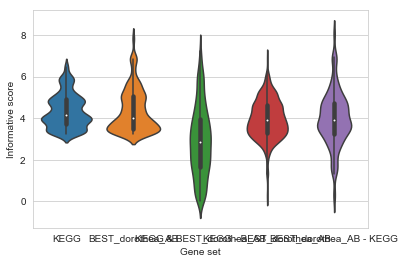

In [416]:
sns.violinplot(x='Gene set',y='Informative score',data=results)